# MadMiner example

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the ML methods introduced in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020), both by Johann Brehmer, Gilles Louppe, Juan Pavez, and Kyle Cranmer.

Before you execute this notebook, make sure you have running installations of MadGraph, Pythia, and Delphes. Note that at least for now, the MG-Pythia interface and Delphes require custom patches (available upon request). In addition, MadMiner and [DelphesMiner](https://github.com/johannbrehmer/delphesminer) have to be in your PYTHONPATH.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

from madminer import GoldMine, Smithy
from madminer.tools.plots import plot_2d_morphing_basis
from delphesminer import DelphesMiner

## 1. Define parameter space

After creating a `GoldMine` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in 1/Lambda) is not taken into account, in which case `morphing_max_power=1`. Finally, the `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

In [2]:
miner = GoldMine()

miner.add_parameter(
    lha_block='ANOINPUTS',
    lha_id=3,
    parameter_name='fW',
    morphing_max_power=4,
    parameter_range=(-1.2e-05,1.2e-05)
)
miner.add_parameter(
    lha_block='ANOINPUTS',
    lha_id=7,
    parameter_name='fWW',
    morphing_max_power=4,
    parameter_range=(-1.2e-05,1.2e-05)
)

## 2. Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

### 2a. Set benchmarks by hand

One can define benchmarks by hand:

In [3]:
miner.add_benchmark(
    {'fW':0., 'fWW':0.},
    'sm'
)

### 2b. Benchmarks for morphing

If morphing is used, the function `set_benchmarks_from_morphing` has to be called. With the option `keep_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points.

In [4]:
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_bases=1,
    n_trials=1000,
    n_test_thetas=100
)

Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space:

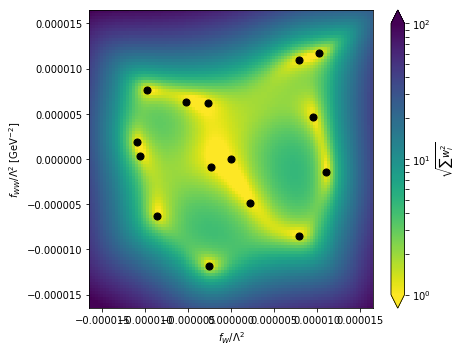

In [5]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$f_{W} / \Lambda^2$ [GeV${}^{-2}$]',
    ylabel=r'$f_{WW} / \Lambda^2$ [GeV${}^{-2}$]',
    xrange=(-1.64949627e-05, 1.64949627e-05),
    yrange=(-1.64949627e-05, 1.64949627e-05),
)

## 3. Save settings and run MadGraph

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [6]:
miner.save('data/madminer_example.h5')

In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You have to provide the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card.

If MadGraph is supposed to run in a different Python environment or requires other setup steps, you can use the `initial_command` argument.

In [7]:
miner.run(
    mg_directory='/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2',
    proc_card_file='./cards/proc_card.dat',
    param_card_template_file='./cards/param_card_template.dat',
    reweight_card_template_file='./cards/reweight_card_template.dat',
    run_card_file='./cards/run_card.dat',
    sample_benchmark='sm',
    initial_command='source activate python2'
)

## 4. Run detector simulation and extract observables

The detector simulation and calculation of observables is not part of MadMiner. The reason is that different users might have very different requirements here: while a phenomenologist might be content with the fast detector simulation from Delphes, an experimental analysis might require the full simulation through Geant4.

We provide the DelphesMiner package, which wraps around Delphes and allows for the fast extraction of observables into the HDF5 file.

Any user is free to replace the DelphesMiner step with a tool of their choice. 

In [8]:
dm = DelphesMiner()

After creating the DelphesMiner object, one can add a number of HepMC event samples...

In [9]:
dm.add_hepmc_sample('./MG_process/Events/run_01/tag_1_pythia8_events.hepmc.gz')

... and have DelphesMiner run Pythia:

In [10]:
dm.run_delphes(delphes_directory='/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/Delphes',
               delphes_card='./cards/delphes_card.dat')

0


The next step is the definition of observables through a name and a python expression. For the latter, you can use the objects `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. All of these objects are scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties.

In [11]:
dm.add_observable('n_jets', 'len(j)')
dm.add_observable('pt_j1', 'j[0].pt')
dm.add_observable('pt_j2', 'j[1].pt')
dm.add_observable('m_jj', '(j[0] + j[1]).m')
dm.add_observable('delta_eta_jj', 'abs(j[0].eta - j[1].eta)')
dm.add_observable('delta_phi_jj', 'abs(j[0].phi() - j[1].phi())')

The function `analyse_delphes_samples` extracts all these observables from the Delphes ROOT file(s) generated before:

In [12]:
dm.analyse_delphes_samples()

Cannot parse observable pt_j1 = j[0].pt (will only show this warning once).
Cannot parse observable pt_j2 = j[1].pt (will only show this warning once).
Cannot parse observable m_jj = (j[0] + j[1]).m (will only show this warning once).
Cannot parse observable delta_eta_jj = abs(j[0].eta - j[1].eta) (will only show this warning once).
Cannot parse observable delta_phi_jj = abs(j[0].phi() - j[1].phi()) (will only show this warning once).


The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [13]:
dm.save('data/madminer_example_with_data.h5', 'data/madminer_example.h5')

It's easy to check some distributions at this stage

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


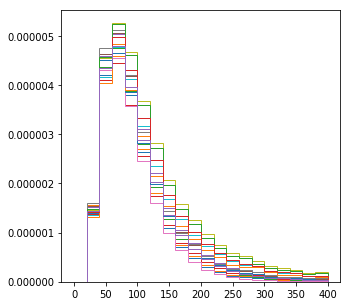

In [15]:
fig = plt.figure(figsize=(5,5))

for weights in dm.weights:
    plt.hist(dm.observations['pt_j1'], range=(0.,400.), bins=20, histtype='step', weights=weights)

plt.show()

## 5. Make training and test samples

The last important MadMiner class is the `Smithy`. From all the data we have in the HDF5 file now, it extracts unweighted samples including the augmented data ("gold") that is needed as training and evaluation data for the Machine Learning algorithms.

In [16]:
smithy = Smithy('data/madminer_example_with_data.h5')

We can check that the information from the original morphing setup is preserved:

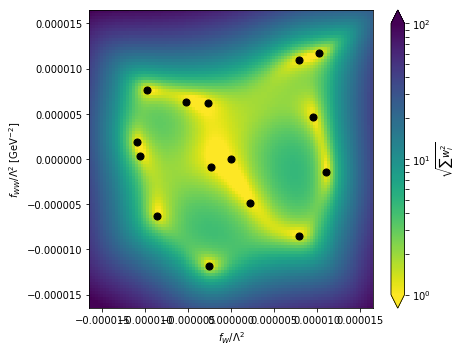

In [17]:
fig = plot_2d_morphing_basis(
    smithy.morpher,
    xlabel=r'$f_{W} / \Lambda^2$',
    ylabel=r'$f_{WW} / \Lambda^2$ [GeV${}^{-2}$]',
    xrange=(-1.64949627e-05, 1.64949627e-05),
    yrange=(-1.64949627e-05, 1.64949627e-05),
)

Let's define the information we want to extract from...

In [18]:
benchmark_index = 1

theta = smithy.benchmarks[list(smithy.benchmarks.keys())[benchmark_index]]
theta = [theta[key] for key in theta]
print(theta)

augmented_data_definitions = [
    ('ratio', 'benchmark', benchmark_index, 'benchmark', 0),
    ('ratio', 'benchmark', benchmark_index, 'morphing', np.array((0.,0.))),
    ('ratio', 'morphing', theta, 'benchmark', 0),
    ('ratio', 'morphing', theta, 'morphing', np.array((0.,0.))),
]

[7.922534565400215e-06, 1.099199311346052e-05]


In [19]:
theta, x, gold = smithy.extract_sample(theta_sampling_types=['benchmark'],
                                       theta_sampling_values=[0],
                                       n_samples_per_theta=10000,
                                       augmented_data_definitions=augmented_data_definitions)

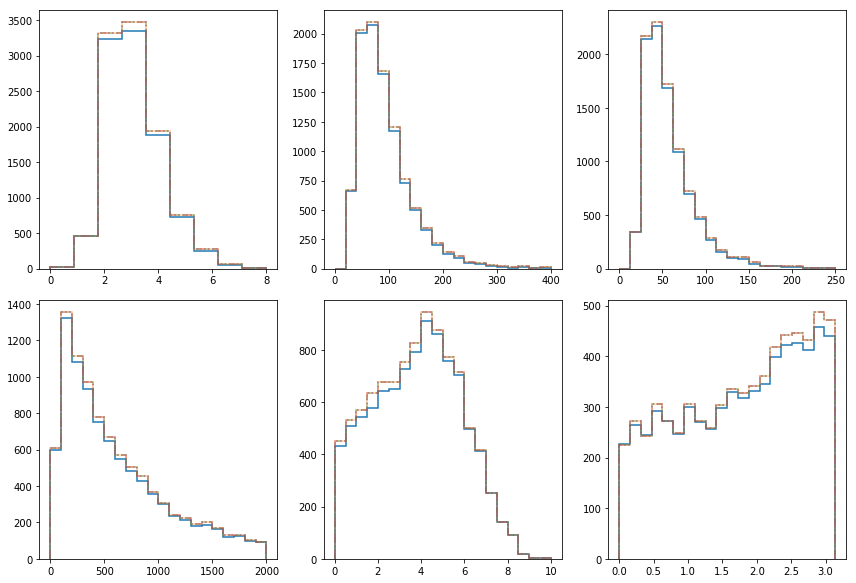

In [27]:
xmin =  [0, 0., 0., 0., 0., 0.]
xmax =  [8, 400., 250., 2000., 10., np.pi]
xbins = [9, 20, 20, 20, 20, 20]

fig = plt.figure(figsize=(12,12))

for i, (this_xmin, this_xmax, this_xbins) in enumerate(zip(xmin, xmax, xbins)):
    ax = plt.subplot(3, 3, i+1)
    
    cut = np.isfinite(x[0][:,i])
    this_data = x[0][cut,i]

    plt.hist(this_data,
             range=(this_xmin, this_xmax), bins=this_xbins,
             histtype='step', lw=1.5, ls='-')
    
    for j in range(gold[0].shape[1]):
        this_weights = gold[0][cut,j]
        plt.hist(this_data, weights=this_weights,
                 range=(this_xmin, this_xmax), bins=this_xbins,
                 histtype='step', lw=1.5, ls=['-', '--', '-.', ':'][j], alpha=0.4)

plt.tight_layout()
plt.show()